# Project 3 -- DATA 620
***
David Moste - Euclid zhang - Samuel Reeves - 6/19/2021

[Presentation Video Link](https://youtu.be/OLxw1I_un6o)
***
# Problem Definition

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

# Data Description

Our data is a large set of male and female names from the names corpus.

# Experimental Strategy

Our strategy in solving this problem was to use a Naive Bayes classifier on a set of features. We determined which features to use by running models on increasingly complicated features until we reached our ideal feature set.

In [ ]:
from nltk.corpus import names
import nltk
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
import string

random.seed(620)

### Preprocessing

Load the names data and covert them to lower case

In [2]:
males = ([(name.lower(), 'male') for name in names.words('male.txt')])
females = ([(name.lower(), 'female') for name in names.words('female.txt')])

len(males)
len(females)

5001

We have about 3000 male names and 5000 female names.

We are going to create the following well balanced training and testing data sets:

* training set: 250 males + 250 females
* development test set: 250 males + 250 females
* test set: all remaining names

In [3]:
random.shuffle(males)
males_train_dev = males[:500]
random.shuffle(females)
females_train_dev = females[:500]

train_set = males_train_dev[:250] + females_train_dev[:250]
dev_test_set = males_train_dev[250:] + females_train_dev[250:]
test_set = males[500:] + females[500:]

In [4]:
len(train_set)
len(dev_test_set)
len(test_set)

6944

The final test set has around 7000 names

***
### Helper functions:

* shuffle_train_devtest() shuffles our training and test sets.
* train_classifier() generates three models based on different classifier functions: naive bayes, decision tree, and Maxent
* add_feat_dev() tests the accuracies of the models trained by two different feature generation functions.


In [5]:
def shuffle_train_devtest():
    random.shuffle(males_train_dev)
    random.shuffle(females_train_dev)
    new_train_set = males_train_dev[:250] + females_train_dev[:250]
    new_dev_test_set = males_train_dev[250:] + females_train_dev[250:]
    return new_train_set, new_dev_test_set

def add_feat_dev(train, test, model_type, feat_function1, feat_function2):
    """Create a table showing the accuracy of a model trained by using feature generation 
    function 1 and the accurary of a model trained by using feature generation function 2
      
    Keyword arguments:
    train -- training data set
    test -- testing data set
    model_type -- the string of the name of the model type. Select one from Naive Bayes, Devision Tree or Max Entropy
    feat_function1 -- feature generation function 1
    feat_function2 -- feature generation function 2
    """
    
    train_feature = [(feat_function1(n),g) for (n,g) in train]
    dev_test_feature = [(feat_function1(n),g) for (n,g) in  test]
    
    dev_results = pd.DataFrame(columns = ['Model', 'train_accuracy','dev_test_accuracy','features'])
    
    def train_classifier():    
        if model_type == 'Naive Bayes':
            classifier = nltk.NaiveBayesClassifier.train(train_feature)
        elif model_type == 'Devision Tree':
            classifier = nltk.DecisionTreeClassifier.train(train_feature)
        elif model_type == 'Max Entropy':
            classifier = nltk.MaxentClassifier.train(train_feature)
        else:
            raise Exception('Please select model type Naive Bayes, Devision Tree or Max Entropy')
        return classifier
    
    classifier = train_classifier()
    
    dev_results.loc[len(dev_results)] = [model_type, nltk.classify.accuracy(classifier, train_feature),
                                       nltk.classify.accuracy(classifier, dev_test_feature), 'Without additional feature']
    
    train_feature = [(feat_function2(n),g) for (n,g) in train]
    dev_test_feature = [(feat_function2(n),g) for (n,g) in  test]
    
    classifier = train_classifier()
    
    dev_results.loc[len(dev_results)] = [model_type, nltk.classify.accuracy(classifier, train_feature),
                                       nltk.classify.accuracy(classifier, dev_test_feature), 'With additional feature']
    return dev_results

### Model Analysis

#### last letter only VS. last letter and last 2 letters

Create feature generation function 1. Features included: <br>
1. last letter of the name

In [6]:
def gender_features(word):
    result = {'last_1': word[-1]}
    return result

Create feature generation function 2. Features included: <br>
1. last letter of the name <br>
2. last 2 letters of the name

In [7]:
def gender_features2(word):
    result = gender_features(word)
    result['last_2'] = word[-2:]
    return result

Compare the accuracies of the two models

In [8]:
add_feat_dev(train_set, dev_test_set, 'Naive Bayes', gender_features, gender_features2)

,Model,train_accuracy,dev_test_accuracy,features
0,Naive Bayes,0.786,0.716,Without additional feature
1,Naive Bayes,0.840,0.738,With additional feature


Including the last 2 letters of the name does increase the accuracy. We would keep the it in our feature set

#### Include last 3 letters or not

Create a new feature generation function. Features included: <br>
1. last letter of the name <br>
2. last 2 letters of the name <br>
3. last 3 letters of the name

In [9]:
def gender_features3(word):
    result = gender_features2(word)
    result['last_3'] = word[-3:]
    return result

Shuffle the training and development testing sets. <br>
Compare the accuracies of the two models

In [10]:
train_set, dev_test_set = shuffle_train_devtest()
add_feat_dev(train_set, dev_test_set, 'Naive Bayes', gender_features2, gender_features3)

,Model,train_accuracy,dev_test_accuracy,features
0,Naive Bayes,0.826,0.770,Without additional feature
1,Naive Bayes,0.886,0.752,With additional feature


Including the last 3 letters of the name helps fitting the data to the model (higher accuracy for the training data). However, the accuracy for the testing data decreases.  We would not include the last 3 letters in our feature set

#### Include first letter or not

In [11]:
def gender_features3(word):
    result = gender_features2(word)
    result['first_1'] = word[0]
    return result

Create a new feature generation function. Features included: <br>
1. last letter of the name <br>
2. last 2 letters of the name <br>
3. first letter of the name

Shuffle the training and development testing sets. <br>
Compare the accuracies of the two models

In [12]:
train_set, dev_test_set = shuffle_train_devtest()
add_feat_dev(train_set, dev_test_set, 'Naive Bayes', gender_features2, gender_features3)

,Model,train_accuracy,dev_test_accuracy,features
0,Naive Bayes,0.820,0.736,Without additional feature
1,Naive Bayes,0.828,0.764,With additional feature


Including the first letter of the name does increase the accuracy. We would keep the it in our feature set

#### Include first 2 letters or not

Create a new feature generation function. Features included: <br>
1. last letter of the name <br>
2. last 2 letters of the name <br>
3. first of the name <br>
4. first 2 letters of the name

In [13]:
def gender_features4(word):
    result = gender_features3(word)
    result['first_2'] = word[0:2]
    return result

Shuffle the training and development testing sets. <br>
Compare the accuracies of the two models

In [14]:
train_set, dev_test_set = shuffle_train_devtest()
add_feat_dev(train_set, dev_test_set, 'Naive Bayes', gender_features3, gender_features4)

,Model,train_accuracy,dev_test_accuracy,features
0,Naive Bayes,0.834,0.790,Without additional feature
1,Naive Bayes,0.872,0.766,With additional feature


This is the second time we see that adding a new feature produces a higher accuracy for the training data, but a lower accuracy for the testing data. Does the frist-two-letter of a name provides no useful information predicting the gender of a name? Let's take a look at the errors of our model without the frist-two-letter

In [15]:
train_feature = [(gender_features3(n),g) for (n,g) in train_set]
#dev_test_feature = [(gender_features3(n),g) for (n,g) in dev_test_set]

NBclassifier = nltk.NaiveBayesClassifier.train(train_feature)

errors = []
for (name, tag) in dev_test_set:
    guess = NBclassifier.classify(gender_features3(name))
    if guess != tag:
        errors.append( (tag, guess, name) )
        
for (tag, guess, name) in sorted(errors): # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    print('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

correct=female   guess=male     name=adriaens                      
correct=female   guess=male     name=aigneis                       
correct=female   guess=male     name=ambur                         
correct=female   guess=male     name=angel                         
correct=female   guess=male     name=beau                          
correct=female   guess=male     name=beth                          
correct=female   guess=male     name=biddy                         
correct=female   guess=male     name=brooks                        
correct=female   guess=male     name=carol-jean                    
correct=female   guess=male     name=christean                     
correct=female   guess=male     name=christin                      
correct=female   guess=male     name=chrysler                      
correct=female   guess=male     name=cybill                        
correct=female   guess=male     name=dorcas                        
correct=female   guess=male     name=ethelind   

we see that a name starting with 'ha' is more likely to be female. The first two letters do provide useful information for prediction.

names start with 'ch'


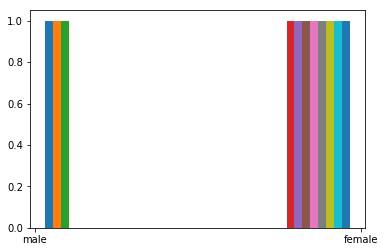

In [18]:
dev_test_df = pd.DataFrame(dev_test_set, columns = ['name', 'gender'])
print('names start with \'ch\'')
data = dev_test_df.loc[[name.startswith('ch') for name in dev_test_df['name']],'gender']
plt.hist(data,bins=3)
plt.show()

But how good is the information?

The following table shows the cases where the training data is not consistent with the testing data.

In [19]:
#all combination of 2 letters
first_2_comb = [u+l for u in list(string.ascii_lowercase) for l in list(string.ascii_lowercase)]

#Threhold for selecting the combination of 2 letters. For example, if x percent of the names start with 'ro' are males
# and y percent of the names start with 'ro' are females and the difference between x and y are higher than the threhold, 
#we will include 'startswith_ro' in feature result 
threshold = 0.35

train_df = pd.DataFrame(train_set, columns = ['name', 'gender'])

first_2_table = pd.DataFrame(columns = ['first_2', 'train_male','train_female','train_male_%','train_female_%',
                                       'test_male','test_female','test_male_%','test_female_%'])
index_counter = 0

for first_2 in first_2_comb:
    train_data = train_df.loc[[name.startswith(first_2) for name in train_df['name']],'gender']
    dev_test_data = dev_test_df.loc[[name.startswith(first_2) for name in dev_test_df['name']],'gender']
    
    if len(dev_test_data) == 0:
        continue
    if (sum(dev_test_data == 'male') < 3) & (sum(dev_test_data == 'female') < 3):
        continue        
    if abs((sum(dev_test_data == 'male') - sum(dev_test_data == 'female'))/len(dev_test_data)) > threshold:
        first_2_table.loc[index_counter] = [first_2,sum(train_data == 'male'),sum(train_data == 'female'),
                                           0 if len(train_data) ==0 else sum(train_data == 'male')/len(train_data),
                                           0 if len(train_data) ==0 else sum(train_data == 'female')/len(train_data),
                                           sum(dev_test_data == 'male'),sum(dev_test_data == 'female'),
                                           0 if len(dev_test_data) ==0 else sum(dev_test_data == 'male')/len(dev_test_data),
                                           0 if len(dev_test_data) ==0 else sum(dev_test_data == 'female')/len(dev_test_data)]
        index_counter = index_counter + 1
        
first_2_table.loc[((first_2_table['train_male_%'] - first_2_table['train_female_%']) * 
                 (first_2_table['test_male_%'] - first_2_table['test_female_%']))<=0]

,first_2,train_male,train_female,train_male_%,train_female_%,test_male,test_female,test_male_%,test_female_%
2,an,7,5,0.583333,0.416667,3,8,0.272727,0.727273
8,ga,0,3,0.000000,1.000000,6,1,0.857143,0.142857
9,ge,3,2,0.600000,0.400000,1,3,0.250000,0.750000
10,go,1,1,0.500000,0.500000,3,1,0.750000,0.250000
11,he,3,3,0.500000,0.500000,1,3,0.250000,0.750000
14,ki,2,1,0.666667,0.333333,1,3,0.250000,0.750000
19,ne,1,4,0.200000,0.800000,4,1,0.800000,0.200000
21,pe,0,1,0.000000,1.000000,3,1,0.750000,0.250000
22,ri,3,5,0.375000,0.625000,4,1,0.800000,0.200000
23,ro,6,11,0.352941,0.647059,8,3,0.727273,0.272727


For example, in the training data set, a name starts with 'ga' is more likely to be female. However, in the development testing data set, a name starts with 'ga' is more likely to be male.

### Problem?

So what problem do we find? Apparently, our training data set is too small to make a good estimation of the probability of the feature values.

In [20]:
len(set([name[0:2] for name,gender in males + females]))

235

In the complete data set of our names, we have 235 unique values for the first two letters. However, we only have 500 names in our training data set. That means we only have average 2-3 cases to eastimate the probability of each first-two-letter feature value. A lot of the feature values may be unseen in our training data set.

If we are lucky, we may have a traning data set by chance that makes a better estimation of the probability of the feature values. Let's keep shuffling our training and development testing data sets and see if we can produce a positive result.

In [21]:
while True:
    train_set, dev_test_set = shuffle_train_devtest()
    result = add_feat_dev(train_set, dev_test_set, 'Naive Bayes', gender_features3, gender_features4)
    display(result)
    if(result['dev_test_accuracy'][1] > result['dev_test_accuracy'][0]):
        break

,Model,train_accuracy,dev_test_accuracy,features
0,Naive Bayes,0.834,0.784,Without additional feature
1,Naive Bayes,0.866,0.756,With additional feature


,Model,train_accuracy,dev_test_accuracy,features
0,Naive Bayes,0.812,0.772,Without additional feature
1,Naive Bayes,0.874,0.768,With additional feature


,Model,train_accuracy,dev_test_accuracy,features
0,Naive Bayes,0.812,0.804,Without additional feature
1,Naive Bayes,0.864,0.786,With additional feature


,Model,train_accuracy,dev_test_accuracy,features
0,Naive Bayes,0.846,0.724,Without additional feature
1,Naive Bayes,0.870,0.744,With additional feature


In our last try, we can see that including the last-two-letter feature increases the model's performance. However, that's purely by chance

### More features or less features?

What will happen if we add more features? For example, adding the count of each vowel appearing in the name

To make a comparison, let's create two functions to help us do the analysis. <br>

The new gender_features function allows you to select different combinations of features to be included

In [22]:
def gender_features(word,first_n = 1,last_n = 1,vowel_count = False):
    """genderate feature values from names based on the feature options selected from the parameters
      
    Keyword arguments:
    word -- the list of names
    first_n -- 1: include the frist letter; 2: include the frist letter and the first two letters;
                3: include the frist letter and the first two letters and the first three letters
    last_n -- 1: include the last letter; 2: include the last letter and the last two letters;
                3: include the last letter and the last two letters and the last three letters
    vowel_count -- include the count of each vowel appearing in the name
    """
    
    result = {}
    
    if first_n == 1:
        result['first_1'] = word[0]
    elif first_n >= 2:
        result['first_1'] = word[0]
        result['first_2'] = word[0:2] if len(word) > 1 else str(len(word))
    elif first_n >= 3:
        result['first_1'] = word[0]
        result['first_2'] = word[0:2] if len(word) > 1 else str(len(word))
        result['first_3'] = word[0:3] if len(word) > 2 else str(len(word))
    
    if last_n == 1:
        result['last_1'] = word[-1]
    elif last_n == 2:
        result['last_1'] = word[-1]
        result['last_2'] = word[-2:] if len(word) > 1 else str(len(word))
    elif last_n >= 3:
        result['last_1'] = word[-1]
        result['last_2'] = word[-2:] if len(word) > 1 else str(len(word))
        result['last_3'] = word[-3:] if len(word) > 2 else str(len(word))
        
    if vowel_count:
        result['a'] = word.count('a')
        result['e'] = word.count('e')
        result['i'] = word.count('i')
        result['o'] = word.count('o')
        result['u'] = word.count('u')
    
    return result

The train_dev_result function generates a table showing the accuracies of the models using all combinations of different feature selections

In [23]:
def train_test_result(train_set, test_set):
    NB_summary = pd.DataFrame(columns = ['first_n', 'last_n','vowel_count','train_accuracy','test_accuracy'])
    
    #index of the next row to enter the test result
    index_counter = 0
    
    #loop: first_n 
    for i in range(0,4):
        #loop: last_n
        for j in range(0,4):
            for v_c in [True, False]:
            #skip the situation with no feature is selected
                if i==0 & j == 0 & (not v_c):
                    continue
                #generate training features
                train_feature = [(gender_features(n,first_n=i,last_n=j,vowel_count=v_c),g) for (n,g) in train_set]
                #generate testing features
                test_feature = [(gender_features(n,first_n=i,last_n=j,vowel_count=v_c),g) for (n,g) in test_set]
                #model training
                NBclassifier = nltk.NaiveBayesClassifier.train(train_feature)
                #record the feature option values, the result accuracy using the training set, 
                #and the result accuracy using the development testing set
                NB_summary.loc[index_counter] = [i,j,v_c,nltk.classify.accuracy(NBclassifier, train_feature),
                                                  nltk.classify.accuracy(NBclassifier, test_feature)]
                #index increasement
                index_counter = index_counter + 1
                #sorting results by the accuracy using the development testing set
                NB_summary = NB_summary.sort_values(by = 'test_accuracy', ascending = False)
     
    #result the result dataframes
    return NB_summary

Let's check the accuraries using the training and development testing data sets

In [24]:
train_test_result(train_set, dev_test_set).head(15)

,first_n,last_n,vowel_count,train_accuracy,test_accuracy
7,1,3,False,0.894,0.746
13,2,2,False,0.870,0.744
21,3,2,False,0.870,0.744
23,3,3,False,0.906,0.744
15,2,3,False,0.906,0.744
20,3,2,True,0.868,0.736
22,3,3,True,0.888,0.736
12,2,2,True,0.868,0.736
14,2,3,True,0.888,0.736
6,1,3,True,0.884,0.732


We can see that adding the vowel_count does not improve the model. Again, the training data set is too small to estimate the probabilies of the added feature values

>However, will the model be improved if we have more data?

Let's do our final performance test. We will train our models with the training data set and development testing set combined. Then we evaluate the models using our test set.

In [25]:
train_test_result(train_set + dev_test_set, test_set).head(15)

,first_n,last_n,vowel_count,train_accuracy,test_accuracy
15,2,3,False,0.891,0.778658
23,3,3,False,0.891,0.778658
22,3,3,True,0.891,0.777938
14,2,3,True,0.891,0.777938
6,1,3,True,0.874,0.777650
20,3,2,True,0.851,0.772465
12,2,2,True,0.851,0.772465
13,2,2,False,0.849,0.771457
21,3,2,False,0.849,0.771457
7,1,3,False,0.874,0.771457


The top models now use more features than they were with smaller training data set

Now, let's expand our traning set to 4000 names and see what happens

In [27]:
train_test_result(males[:2000] + females[:2000], males[2000:] + females[2000:]).head(15)

,first_n,last_n,vowel_count,train_accuracy,test_accuracy
14,2,3,True,0.84825,0.807302
22,3,3,True,0.84825,0.807302
23,3,3,False,0.84575,0.804513
15,2,3,False,0.84575,0.804513
20,3,2,True,0.81725,0.795385
12,2,2,True,0.81725,0.795385
21,3,2,False,0.81225,0.793864
13,2,2,False,0.81225,0.793864
11,2,1,False,0.77350,0.785497
19,3,1,False,0.77350,0.785497


Now, the model uses all features (first 3 + last 3 + vowel_count) finally hits rank 1

# Conclusion

When building a model with a small data set, fewer features should be select. Adding more features can even lower the model's performance when we don't have enough data to make a good estimation of the probabilities the feature values. When our data set if large, adding new features properly can help the data better fit the model and therefore increase its performance.